In [85]:
%matplotlib inline
import numpy as np
from numpy import random as rng
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcess
from scipy import stats
from matplotlib import cm
np.set_printoptions(precision = 1)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [86]:
# Standard normal distribution functions
phi = stats.distributions.norm().pdf
PHI = stats.distributions.norm().cdf
PHIinv = stats.distributions.norm().ppf

# A few constants
lim = 8


def g(x):
    """The function to predict """
    return 5. - x[:, 1] - .5 * x[:, 0] ** 2.

In [98]:
# Design of experiments
X = np.array([[-4.61611719, -6.00099547],
              [4.10469096, 5.32782448],
              [0.00000000, -0.50000000],
              [-6.17289014, -4.6984743],
              [1.3109306, -6.93271427],
              [-5.03823144, 3.10584743],
              [-2.87600388, 6.74310541],
              [5.21301203, 4.26386883]])

# Observations
y = g(X)
y_min = np.min(y)
y = y - y_min + 0.1

In [99]:
# Instanciate and fit Gaussian Process Model
gp = GaussianProcess(theta0=5e-1)
# Don't perform MLE or you'll get a perfect prediction for this simple example!
gp.fit(X, y)

# Evaluate real function, the prediction and its MSE on a grid
res = 100
x1, x2 = np.meshgrid(np.linspace(- lim, lim, res),
                     np.linspace(- lim, lim, res))
xx = np.vstack([x1.reshape(x1.size), x2.reshape(x2.size)]).T
# xx has res^2 rows (one for each pixel), and 2 columns (the x and y vals)
y_true = g(xx)  # the true function
y_pred, MSE = gp.predict(xx, eval_MSE=True)  # the gp predicted means and variances
# Those will be res^2 rows, 1 column
sigma = np.sqrt(MSE)
# now reconvert them from to "image" shapes
y_true = y_true.reshape((res, res))
y_pred = y_pred.reshape((res, res))
sigma = sigma.reshape((res, res))
u = (y_pred - np.mean(y))/sigma

best_so_far = np.max(y)
u = (y_pred - best_so_far)/sigma

#Phi = 0.5*erf(u/sqrt(2)) + 0.5
#phi = 1.0/sqrt(2*pi) * exp(-pow(u,2)/2.0)

EI = sigma*(u*PHI(u)  + phi(u))
EI = EI.reshape((res, res))

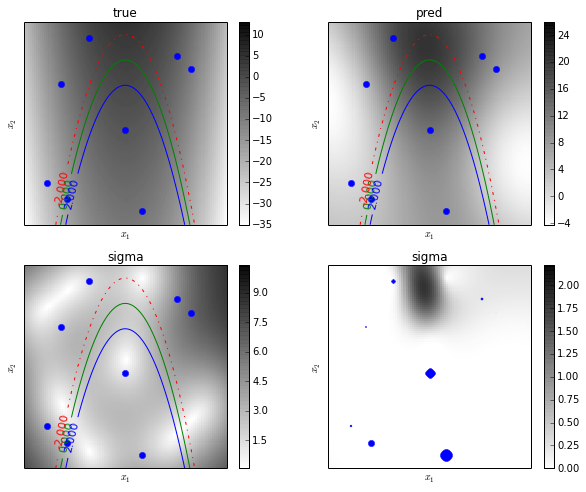

In [100]:


# Get ready to plot the predictions etc.
plt.clf()
fig = pl.figure(1)

ax = fig.add_subplot(221)
ax.axes.set_aspect('equal')
pl.xticks([])
pl.yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
pl.xlabel('$x_1$')
pl.ylabel('$x_2$')

cax = pl.imshow(y_true, cmap=cm.gray_r, alpha=0.8, extent=(- lim, lim, - lim, lim))
pl.title('true')
norm = pl.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
cb = pl.colorbar(cax, norm=norm)
#cb.set_label('${\\rm \mathbb{P}}\left[\widehat{G}(\mathbf{x}) \leq 0\\right]$')

pl.plot(X[y <= 0, 0], X[y <= 0, 1], 'r.', markersize=12)
pl.plot(X[y > 0, 0], X[y > 0, 1], 'b.', markersize=12)

cs = pl.contour(x1, x2, y_true, [0.], colors='g', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [2.0], colors='b', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [-2.0], colors='r', linestyles='dashdot')
pl.clabel(cs, fontsize=11)

#--------------------------------------
ax = fig.add_subplot(222)
ax.axes.set_aspect('equal')
pl.xticks([])
pl.yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
pl.xlabel('$x_1$')
pl.ylabel('$x_2$')

cax = pl.imshow(y_pred, cmap=cm.gray_r, alpha=0.8, extent=(- lim, lim, - lim, lim))
pl.title('pred')
#norm = pl.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
cb = pl.colorbar(cax, norm=norm)
#cb.set_label('${\\rm \mathbb{P}}\left[\widehat{G}(\mathbf{x}) \leq 0\\right]$')

pl.plot(X[y <= 0, 0], X[y <= 0, 1], 'r.', markersize=12)
pl.plot(X[y > 0, 0], X[y > 0, 1], 'b.', markersize=12)

cs = pl.contour(x1, x2, y_true, [0.], colors='g', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [2.0], colors='b', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [-2.0], colors='r', linestyles='dashdot')
pl.clabel(cs, fontsize=11)

#--------------------------------------
ax = fig.add_subplot(223)
ax.axes.set_aspect('equal')
pl.xticks([])
pl.yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
pl.xlabel('$x_1$')
pl.ylabel('$x_2$')

cax = pl.imshow(sigma, cmap=cm.gray_r, alpha=0.8, extent=(- lim, lim, - lim, lim))
pl.title('sigma')
norm = pl.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
cb = pl.colorbar(cax, norm=norm)
#cb.set_label('${\\rm \mathbb{P}}\left[\widehat{G}(\mathbf{x}) \leq 0\\right]$')

pl.plot(X[y <= 0, 0], X[y <= 0, 1], 'r.', markersize=12)
pl.plot(X[y > 0, 0], X[y > 0, 1], 'b.', markersize=12)

cs = pl.contour(x1, x2, y_true, [0.], colors='g', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [2.0], colors='b', linestyles='solid')
pl.clabel(cs, fontsize=11)

cs = pl.contour(x1, x2, y_true, [-2.0], colors='r', linestyles='dashdot')
pl.clabel(cs, fontsize=11)

#--------------------------------------
ax = fig.add_subplot(224)
ax.axes.set_aspect('equal')
pl.xticks([])
pl.yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
pl.xlabel('$x_1$')
pl.ylabel('$x_2$')

cax = pl.imshow(EI, cmap=cm.gray_r, alpha=0.8, extent=(- lim, lim, - lim, lim))
pl.title('sigma')
#norm = pl.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
cb = pl.colorbar(cax)

#for i,z in enumerate(X):
#    pl.plot(z[0], z[1], 'b.', markersize=y[i])
#--------------------------------------------
pl.show()